In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
from scipy.stats import ttest_ind
from scipy import stats


Replace the following cell with the data obtained in your user study. The lists contain subslist with all ratings for each document.

In [ ]:
# Data
read_synthetic = [[4, 3, 2, 4, 3, 4, 5, 2, 5, 4], [4, 2, 3, 4, 2, 1, 3, 3, 2, 4], [3, 4, 3, 3, 3, 3, 5, 2, 5, 5]]
read_real = [[3, 5, 4, 4, 5, 4, 4, 2, 5, 4], [3, 4, 4, 4, 3, 2, 4, 2, 5, 4], [3, 4, 5, 4, 4, 2, 3, 3, 3, 4]]
mc_synthetic = [[4, 3, 3, 4, 3, 2, 5, 2, 5, 4], [3, 2, 3, 4, 4, 2, 3, 3, 2, 4], [2, 3, 1, 3, 4, 4, 5, 2, 5, 4]]
mc_real = [[2, 5, 4, 4, 5, 4, 4, 2, 5, 4], [3, 4, 5, 3, 3, 2, 5, 3, 5, 3], [4, 4, 4, 4, 3, 2, 3, 2, 3, 4]]

readability = [4, 3, 2, 4, 3, 4, 5, 2, 5, 4, 4, 2, 3, 4, 2, 1, 3, 3, 2, 4, 3, 4, 3, 3, 3, 3, 5, 2, 5, 5, 3, 5, 4, 4, 5, 4, 4, 2, 5, 4, 3, 4, 4, 4, 3, 2, 4, 2, 5, 4, 3, 4, 5, 4, 4, 2, 3, 3, 3, 4]
medical_coherence = [4, 3, 3, 4, 3, 2, 5, 2, 5, 4, 3, 2, 3, 4, 4, 2, 3, 3, 2, 4, 2, 3, 1, 3, 4, 4, 5, 2, 5, 4, 2, 5, 4, 4, 5, 4, 4, 2, 5, 4, 3, 4, 5, 3, 3, 2, 5, 3, 5, 3, 4, 4, 4, 4, 3, 2, 3, 2, 3, 4]

Plot for ratings for each document

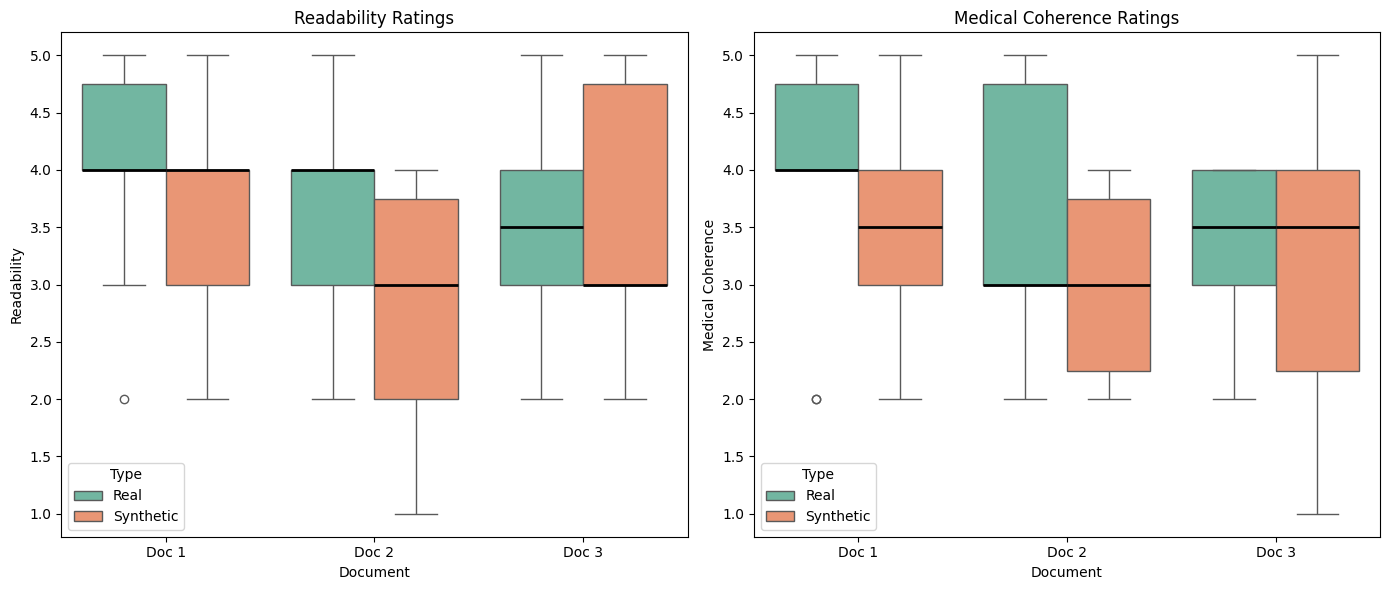

In [ ]:
# Create DataFrames for Readability and Medical Coherence
data_read = {
    'Document': ['Doc 1'] * len(read_real[0]) + ['Doc 2'] * len(read_real[1]) + ['Doc 3'] * len(read_real[2]) + \
                ['Doc 1'] * len(read_synthetic[0]) + ['Doc 2'] * len(read_synthetic[1]) + ['Doc 3'] * len(read_synthetic[2]),
    'Type': ['Real'] * sum(len(doc) for doc in read_real) + ['Synthetic'] * sum(len(doc) for doc in read_synthetic),
    'Readability': sum(read_real, []) + sum(read_synthetic, [])
}

data_mc = {
    'Document': ['Doc 1'] * len(mc_real[0]) + ['Doc 2'] * len(mc_real[1]) + ['Doc 3'] * len(mc_real[2]) + \
                ['Doc 1'] * len(mc_synthetic[0]) + ['Doc 2'] * len(mc_synthetic[1]) + ['Doc 3'] * len(mc_synthetic[2]),
    'Type': ['Real'] * sum(len(doc) for doc in mc_real) + ['Synthetic'] * sum(len(doc) for doc in mc_synthetic),
    'Medical Coherence': sum(mc_real, []) + sum(mc_synthetic, [])
}

df_read = pd.DataFrame(data_read)
df_mc = pd.DataFrame(data_mc)

plt.figure(figsize=(14, 6))

# Box plot for Readability
plt.subplot(1, 2, 1)
sns.boxplot(x='Document', y='Readability', hue='Type', data=df_read, palette="Set2", medianprops=dict(color="black", linewidth=2))
plt.title("Readability Ratings")
plt.xlabel("Document")
plt.ylabel("Readability")
plt.legend(title='Type')

# Box plot for Medical Coherence
plt.subplot(1, 2, 2)
sns.boxplot(x='Document', y='Medical Coherence', hue='Type', data=df_mc, palette="Set2", medianprops=dict(color="black", linewidth=2))
plt.title("Medical Coherence Ratings")
plt.xlabel("Document")
plt.ylabel("Medical Coherence")
plt.legend(title='Type')

plt.tight_layout()
plt.savefig("study_boplot_docs.png")
plt.show()

Check statistical significance for each document pair

In [ ]:
read_data = [np.concatenate((read_real[i], read_synthetic[i])) for i in range(3)]
mc_data = [np.concatenate((mc_real[i], mc_synthetic[i])) for i in range(3)]

# Perform t-tests for each document and category
results = {}

# Readability
for i in range(3):  
    t_stat, p_value = stats.ttest_ind(read_real[i], read_synthetic[i])
    results[f'Readability Doc {i+1}'] = {'t-statistic': t_stat, 'p-value': p_value}

# Medical Coherence
for i in range(3): 
    t_stat, p_value = stats.ttest_ind(mc_real[i], mc_synthetic[i])
    results[f'Medical Coherence Doc {i+1}'] = {'t-statistic': t_stat, 'p-value': p_value}
results


{'Readability Doc 1': {'t-statistic': 0.8846517369293826,
  'p-value': 0.38800910715171777},
 'Readability Doc 2': {'t-statistic': 1.5609177071190494,
  'p-value': 0.13595252797946403},
 'Readability Doc 3': {'t-statistic': -0.230769230769231,
  'p-value': 0.8200966948053492},
 'Medical Coherence Doc 1': {'t-statistic': 0.8203031124295955,
  'p-value': 0.4227738849317938},
 'Medical Coherence Doc 2': {'t-statistic': 1.405563856997455,
  'p-value': 0.1768796480794003},
 'Medical Coherence Doc 3': {'t-statistic': 0.0, 'p-value': 1.0}}

Cohens's Kappa, statistic and plotting for all documents

In [ ]:
read_synthetic_flat = np.concatenate(read_synthetic)
read_real_flat = np.concatenate(read_real)
mc_synthetic_flat = np.concatenate(mc_synthetic)
mc_real_flat = np.concatenate(mc_real)

t_read, p_read = ttest_ind(read_synthetic_flat, read_real_flat, equal_var=False)
t_mc, p_mc = ttest_ind(mc_synthetic_flat, mc_real_flat, equal_var=False)

data = pd.DataFrame({
    'Readability': np.concatenate([read_synthetic_flat, read_real_flat]),
    'Medical Coherence': np.concatenate([mc_synthetic_flat, mc_real_flat]),
    'Type': ['Synthetic'] * len(read_synthetic_flat) + ['Real'] * len(read_real_flat)
})

means = data.groupby('Type').mean()
stds = data.groupby('Type').std()

# Inter-annotator agreement with Cohen's Kappa
kappas_read = [cohen_kappa_score(read_synthetic[i], read_real[i]) for i in range(3)]
kappas_mc = [cohen_kappa_score(mc_synthetic[i], mc_real[i]) for i in range(3)]
mean_kappa_read = np.mean(kappas_read)
mean_kappa_mc = np.mean(kappas_mc)

print("Mean Ratings:\n", means)
print("\nStandard Deviations:\n", stds)
print("\nMean Cohen's Kappa for Readability:", mean_kappa_read)
print("Mean Cohen's Kappa for Medical Coherence:", mean_kappa_mc)
print("\nT-Test for Readability: t =", t_read, ", p =", p_read)
print("T-Test for Medical Coherence: t =", t_mc, ", p =", p_mc)

# Plotting
plt.figure(figsize=(14, 6))

# Box plot for Readability and Medical Coherence
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Readability', data=data, palette="Set2", medianprops=dict(color="black", linewidth=2))
plt.title("Readability Ratings")

plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y='Medical Coherence', data=data, palette="Set2", medianprops=dict(color="black", linewidth=2))
plt.title("Medical Coherence Ratings")

plt.tight_layout()
plt.savefig("study_all.png")

Mean Ratings:
            Readability  Medical Coherence
Type                                     
Real          3.666667           3.600000
Synthetic     3.333333           3.266667

Standard Deviations:
            Readability  Medical Coherence
Type                                     
Real          0.922266           1.003442
Synthetic     1.093345           1.080655

Mean Cohen's Kappa for Readability: 0.026237587881423496
Mean Cohen's Kappa for Medical Coherence: 0.062462462462462454

T-Test for Readability: t = -1.2764064725415898 , p = 0.2070430266226324
T-Test for Medical Coherence: t = -1.2380507081801502 , p = 0.22071251005596954


Plot correlation between readability and medical coherence and calculate correlation coefficients

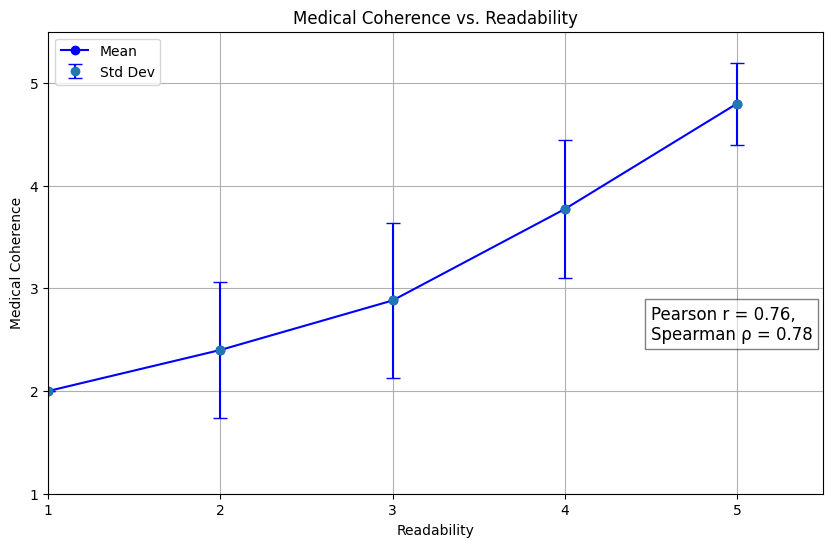

Pearson Correlation Coefficient: 0.7638574776675627
Pearson P-value: 1.2583688841835332e-12
Spearman Correlation Coefficient: 0.7789185451052614
Spearman P-value: 2.337917850883415e-13


In [ ]:
flat_read_synthetic = [rating for sublist in read_synthetic for rating in sublist]
flat_read_real = [rating for sublist in read_real for rating in sublist]
flat_mc_synthetic = [rating for sublist in mc_synthetic for rating in sublist]
flat_mc_real = [rating for sublist in mc_real for rating in sublist]

# Combine all readability and medical coherence ratings
all_readability = flat_read_synthetic + flat_read_real
all_coherence = flat_mc_synthetic + flat_mc_real

# Calculate Pearson and Spearman correlation coefficients
pearson_coefficient, pearson_p_value = pearsonr(all_readability, all_coherence)
spearman_coefficient, spearman_p_value = spearmanr(all_readability, all_coherence)

# Calculate correlation coefficients
pearson_corr, pearson_p = pearsonr(all_readability, all_coherence)
spearman_corr, spearman_p = spearmanr(all_readability, all_coherence)

data_dict = defaultdict(list)
for r, m in zip(readability, medical_coherence):
    data_dict[r].append(m)

means = []
std_devs = []
unique_readabilities = sorted(data_dict.keys())

for r in unique_readabilities:
    values = data_dict[r]
    means.append(np.mean(values))
    std_devs.append(np.std(values))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(unique_readabilities, means, marker='o', linestyle='-', color='blue', label='Mean')
plt.errorbar(unique_readabilities, means, yerr=std_devs, fmt='o', ecolor='blue', capsize=5, linestyle='None', label='Std Dev')
plt.title('Medical Coherence vs. Readability')
plt.xlabel('Readability')
plt.ylabel('Medical Coherence')
plt.xlim(1, 5.5)
plt.ylim(1, 5.5)
plt.xticks(range(1, 6)) 
plt.yticks(range(1, 6)) 
plt.grid(True)
plt.legend()

# Show correlation coefficients in the plot
plt.text(4.5, 2.5, f'Pearson r = {pearson_corr:.2f}, \nSpearman ρ = {spearman_corr:.2f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.savefig("study_correlation.png")
plt.show()

print(f'Pearson Correlation Coefficient: {pearson_corr}')
print(f'Pearson P-value: {pearson_p}')
print(f'Spearman Correlation Coefficient: {spearman_corr}')
print(f'Spearman P-value: {spearman_p}')